#### tf.keras.layers.BatchNormalization
* tf.keras.layers.BatchNormalization(
    axis=-1,
    momentum=0.99,
    epsilon=0.001,
    center=True,
    scale=True,
    beta_initializer='zeros',
    gamma_initializer='ones',
    moving_mean_initializer='zeros',
    moving_variance_initializer='ones',
    beta_regularizer=None,
    gamma_regularizer=None,
    beta_constraint=None,
    gamma_constraint=None,
    synchronized=False,
    **kwargs
)

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , BatchNormalization, Reshape ,UpSampling2D
from tensorflow.keras.layers import Activation , Conv2D , LeakyReLU , Dropout ,Flatten
generator = Sequential()
generator.add(Dense(128*7*7, input_dim=100, activation=LeakyReLU(0.2)))
generator.add(BatchNormalization())
generator.add(Reshape((7,7,128)))
generator.add(UpSampling2D())
generator.add(Conv2D(64, kernel_size=5, padding='same'))
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(0.2)))
generator.add(UpSampling2D())
generator.add(Conv2D(1, kernel_size=5, padding='same', activation='tanh'))


In [8]:
generator.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 6272)              633472    
                                                                 
 batch_normalization_4 (Bat  (None, 6272)              25088     
 chNormalization)                                                
                                                                 
 reshape_2 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_4 (UpSamplin  (None, 14, 14, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 64)        204864    
                                                                 
 batch_normalization_5 (Bat  (None, 14, 14, 64)       

In [9]:
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, input_shape=(28,28,1),padding='same'))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128,kernel_size=5,strides=2,padding='same'))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer='adam')
discriminator.trainable=False

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 100)]             0         
                                                                 
 sequential_4 (Sequential)   (None, 28, 28, 1)         865281    
                                                                 
 sequential_5 (Sequential)   (None, 1)                 212865    
                                                                 
Total params: 1078146 (4.11 MB)
Trainable params: 852609 (3.25 MB)
Non-trainable params: 225537 (881.00 KB)
_________________________________________________________________
(32, 28, 28, 1)
1/1 [==============================] - 0s 70ms/step
epoch:0 d_loss:0.1845116838812828 g_loss:2.0301804542541504
1/1 [==============================] - 0s 86ms/step
(32, 28, 28, 1)
1/1 [==============================] - 0s 51ms/step
epoch:1 d_loss:0.255632247775793

C:\Users\user\AppData\Local\Temp\ipykernel_16404\95575514.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(5,5)


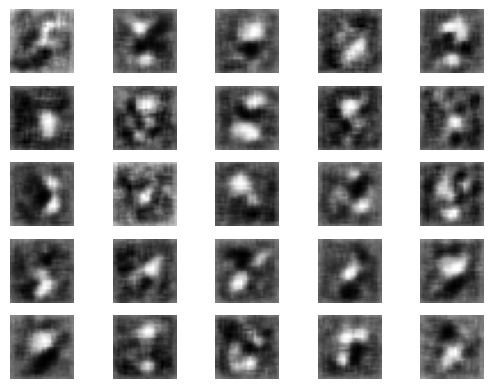

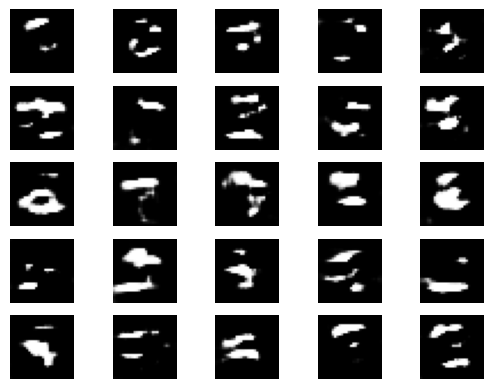

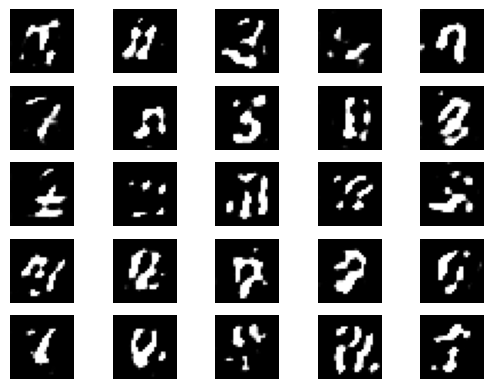

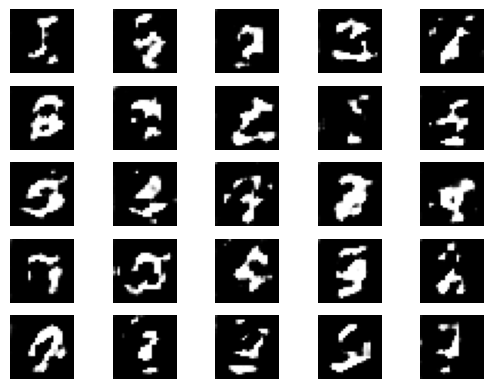

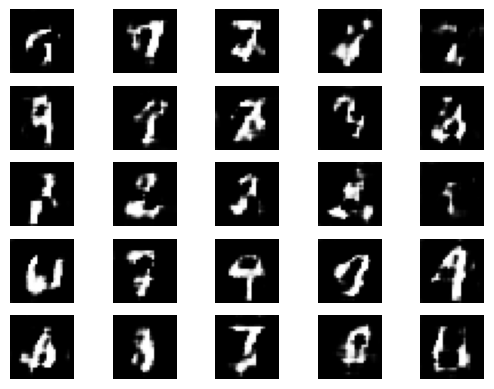

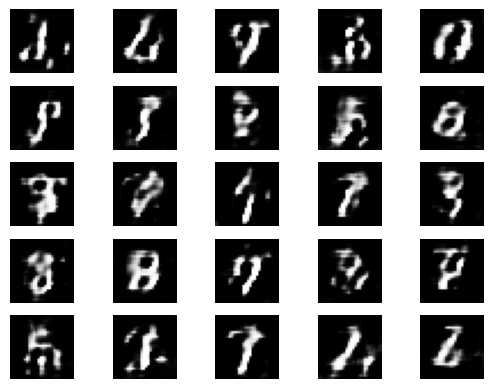

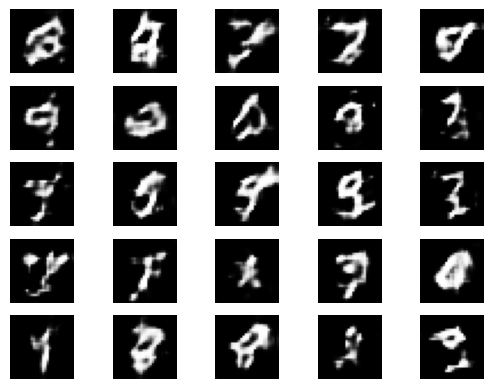

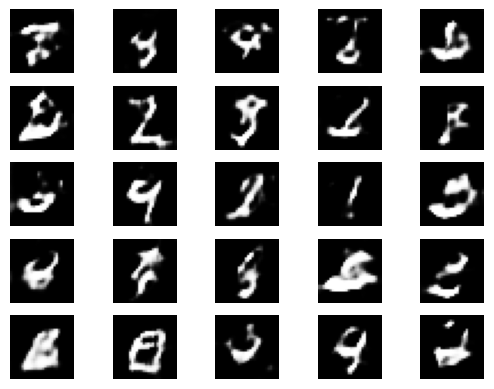

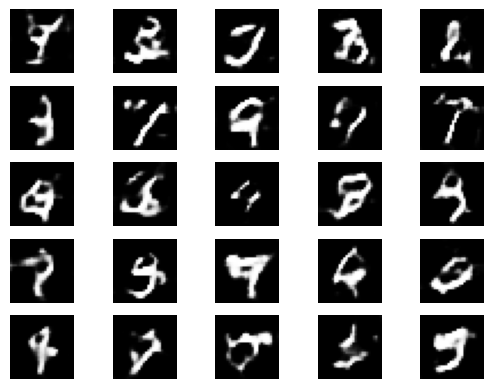

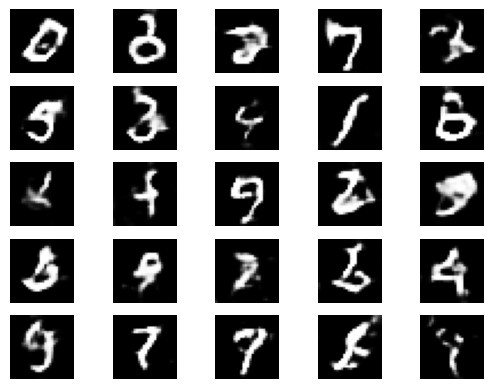

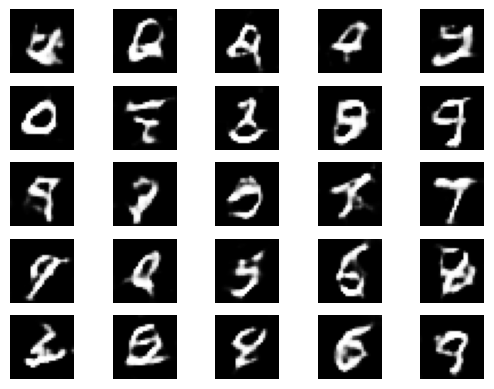

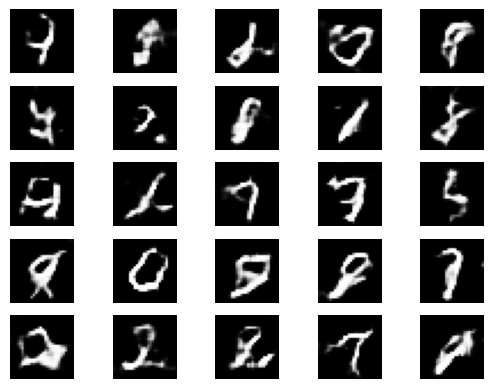

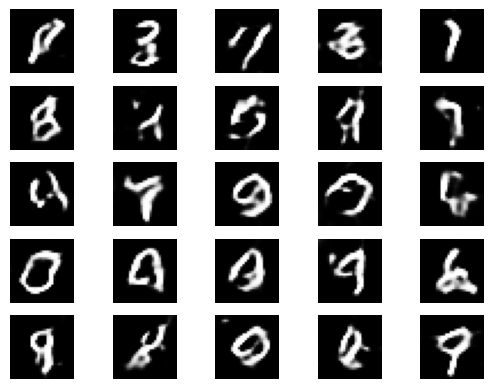

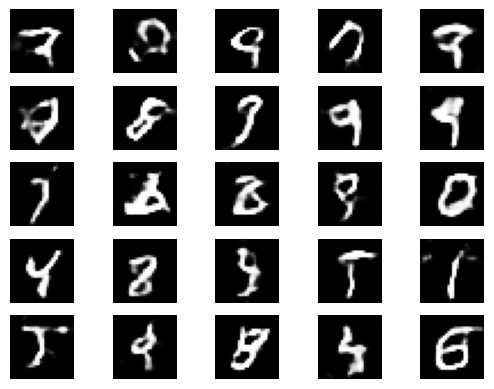

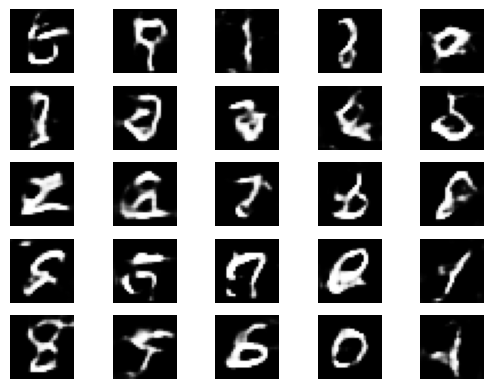

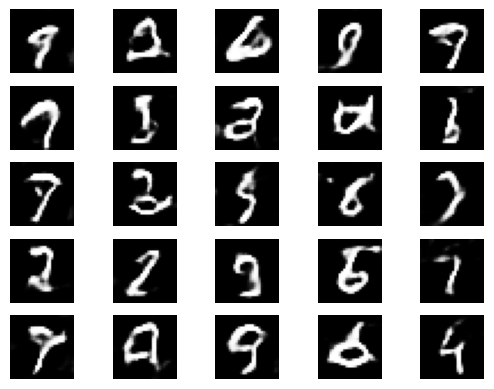

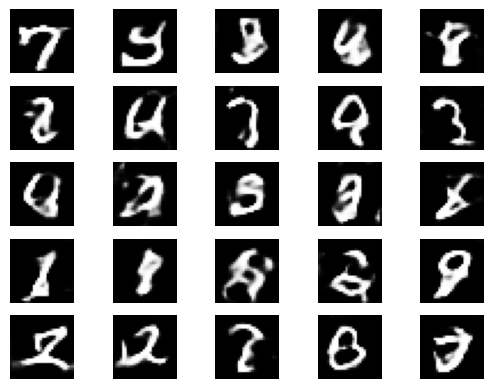

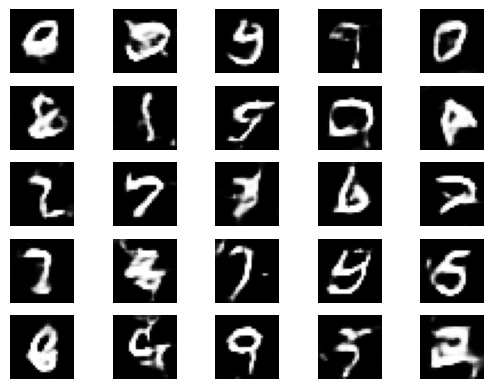

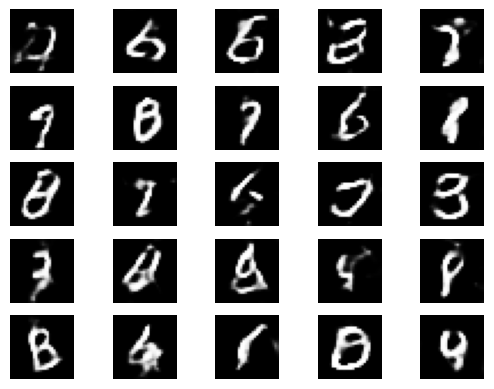

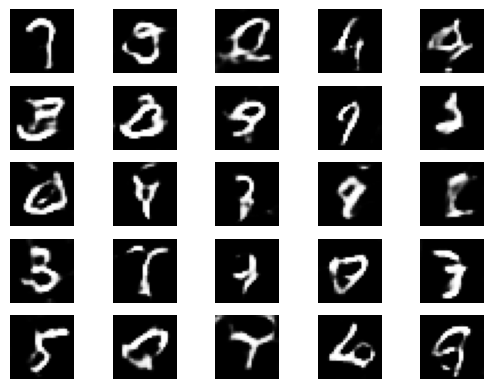

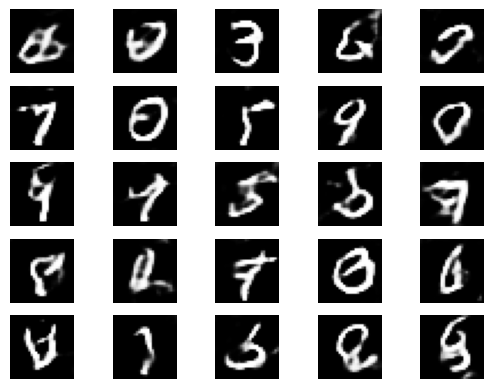

In [33]:
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Input
from tensorflow.keras.datasets  import mnist
import numpy as np 
import matplotlib.pyplot as plt

ginput= Input(shape=(100,))
dis_output = discriminator(generator(ginput))
gan = Model(ginput, dis_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')
gan.summary()

def gan_train(epoch, batch_size, saving_interval):
    (x_train,_),(_,_) = mnist.load_data()
    x_train = x_train.reshape(x_train.shape[0],28,28,1).astype('float32')
    x_train = (x_train-127.5)/127.5

    true = np.ones((batch_size,1))
    fake = np.zeros((batch_size,1))

    for i in range(epoch):

        idx = np.random.randint(0,x_train.shape[0], batch_size)
        imgs = x_train[idx]
        print(imgs.shape)
        # plt.imshow(imgs, cmap='Greys')
        d_loss_real = discriminator.train_on_batch(imgs,true)
        # print(d_loss_real)
        noise = np.random.normal(0,1, (batch_size,100))
        gen_imgs = generator.predict(noise)
        d_loss_fake = discriminator.train_on_batch(gen_imgs,fake)
        # print(d_loss_fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        g_loss = gan.train_on_batch(noise,true)
        
        print(f'epoch:{i}',f'd_loss:{d_loss}', f'g_loss:{g_loss}')

        if i % saving_interval == 0 :
            # noise= np.random.normal(0,1,(25,100))
            gen_imgs = generator.predict(noise)
        
            gen_imgs = 0.5 * gen_imgs+0.5
        
            fig, axs = plt.subplots(5,5)
            count= 0 
            for j in range(5):
                for k in range(5):
                    axs[j,k].imshow(gen_imgs[count,:,:,0], cmap='gray')
                    axs[j,k].axis('off')
                    count = count+1
                    fig.savefig(f'gan_images/gan_mnist_{i}.png')
                    

gan_train(4001,32,200)
        

In [31]:
gan_train(10, 30,32)

(30, 28, 28, 1)
0.02227482758462429
1/1 [==============================] - 0s 44ms/step
0.5302974581718445
epoch:0 d_loss:0.2762861428782344 g_loss:1.2792330980300903
(30, 28, 28, 1)
0.01033550500869751
1/1 [==============================] - 0s 50ms/step
0.8296269774436951
epoch:1 d_loss:0.4199812412261963 g_loss:0.22222286462783813
(30, 28, 28, 1)
0.004608561284840107
1/1 [==============================] - 0s 48ms/step
0.8987389802932739
epoch:2 d_loss:0.451673770789057 g_loss:0.09353304654359818
(30, 28, 28, 1)
0.005075898952782154
1/1 [==============================] - 0s 65ms/step
0.9067176580429077
epoch:3 d_loss:0.45589677849784493 g_loss:0.12696696817874908
(30, 28, 28, 1)
0.013638561591506004
1/1 [==============================] - 0s 56ms/step
0.7003385424613953
epoch:4 d_loss:0.35698855202645063 g_loss:0.3243125379085541
(30, 28, 28, 1)
0.05983225628733635
1/1 [==============================] - 0s 89ms/step
0.45104849338531494
epoch:5 d_loss:0.25544037483632565 g_loss:1.108968

In [37]:
import imageio
anim_file = 'dcgan.gif'
import glob

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('gan_images/gan_mnist_*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

C:\Users\user\AppData\Local\Temp\ipykernel_16404\2798970512.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
C:\Users\user\AppData\Local\Temp\ipykernel_16404\2798970512.py:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)